# Sense of humour replication

Today's state of the art in sense of humour is held by carbon-based lifeforms and biological neural networks. Machine learning has proven an invaluable tool in a lot of other domains so in all likelihood lack of progress in artificial sense of humour is a consequence of acute lack of imagination as opposed to technological limitations.

## Library

Import everything we need for experiments

In [1]:
import pandas as pd
import numpy as np
import itertools

/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [87]:
import torch
from torch import nn
import torch.nn.functional as F

normal_dist = torch.distributions.Normal(0, 1)

## Research log

Experments

In [25]:
tweets = pd.read_json('tweets.json')
tweets

,favoriteCount,hashtags,id,images,isPinned,isReplyTo,isRetweet,quote,replyCount,retweetCount,screenName,text,time,urls,userMentions
0,60,[],1041292992697524224,[],False,False,False,NaN,0,9,alg_testament,"Колесница же пришла к нему, как было прочитано...",2018-09-16T11:49:30.000Z,[],[]
1,73,[],1041014791060508672,[],False,False,False,NaN,0,12,alg_testament,Такое описание динамического программирования ...,2018-09-15T17:24:01.000Z,[],[]
2,70,[],1038816942927343616,[],False,False,False,NaN,0,15,alg_testament,Описания этих констант мы будем воспевать и пр...,2018-09-09T15:50:34.000Z,[],[]
3,34,[],1037333768649015296,[],False,False,False,NaN,0,4,alg_testament,"Во-первых, значение errno никогда не будет вхо...",2018-09-05T13:36:57.000Z,[],[]
4,50,[],1034441287234150400,[],False,False,False,NaN,0,8,alg_testament,"Графы, моделирующие сети до­ рог, являются раз...",2018-08-28T14:03:16.000Z,[],[]
5,21,[],1031902155286822912,[],False,False,False,NaN,0,0,alg_testament,дети не должны использоваться эти две функции ...,2018-08-21T13:53:40.000Z,[],[]
6,52,[],1031175336480923648,[],False,False,False,NaN,0,6,alg_testament,Стандартная библиотека ввода/вывода не давала ...,2018-08-19T13:45:33.000Z,[],[]
7,62,[],1030440751669366784,[],False,False,False,NaN,0,14,alg_testament,ОС Solaris в рамках проекта открытой ОС OpenSo...,2018-08-17T13:06:34.000Z,[],[]
8,77,[],1029388671999533056,[],False,False,False,NaN,0,14,alg_testament,и рассею их в пределах одной файловой системы.,2018-08-14T15:25:59.000Z,[],[]
9,204,[],1028635730023776256,[],False,False,False,NaN,0,47,alg_testament,"Адония, сын Аггифы, возгордившись говорил: я б...",2018-08-12T13:34:03.000Z,[],[]


In [35]:
y = np.array(tweets['favoriteCount'])

### Bag of words models

In [276]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [286]:
import numpy as np

X = np.array(tweets['text'])
X = vectorizer.fit_transform(X)

In [287]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [288]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

In [289]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [290]:
linear.fit(X_train, y_train)
linear.score(X_test, y_test)

-0.01090327786881984

In [291]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

-0.10390982194621778

### Byte pair embedding models

Summing up all [byte-pair embeddings](https://github.com/bheinzerling/bpemb) to get a sentence embedding and use it as the input vector

In [8]:
import sentencepiece as spm
from gensim.models import KeyedVectors

/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [19]:
bpe_model_location = 'ru.wiki.bpe.op100000.model'
bpe_vec_location = 'ru.wiki.bpe.op100000.d300.w2v.bin'

sp = spm.SentencePieceProcessor()
sp.Load(bpe_model_location)
model = KeyedVectors.load_word2vec_format(bpe_vec_location, binary=True)

def bpe_embed(text):
    pieces = sp.encode_as_pieces(text)
    embedding = np.zeros(model.vector_size)
    piece_count = 0

    for binary_piece in pieces:
        piece = binary_piece.decode('utf-8')
        try:
            embedding += model[piece]
            piece_count += 1
        except KeyError:
            pass

    if piece_count:
        embedding /= piece_count
            
    return embedding

In [51]:
X_bpe = np.array(list(map(embed, tweets['text'])))

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bpe, y)

/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [40]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor()

/home/vadim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [43]:
linear.fit(X_train, y_train)
randomforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
linear.score(X_test, y_test)

-1.2238193615848458

In [45]:
randomforest.score(X_test, y_test)

-0.050204528829113526

### Sequence models

Treating tweets as sequences of chunk embeddings

In [24]:
def sequence_bpe_embed(text):
    pieces = sp.encode_as_pieces(text)
    embedding = []

    for binary_piece in pieces:
        piece = binary_piece.decode('utf-8')
        try:
            embedding.append(model[piece])
        except KeyError:
            pass
            
    return np.array(embedding)

In [87]:
X_seq = [sequence_bpe_embed(t) for t in tweets['text']]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y)

In [109]:
import torch
from torch import nn
from torch.optim import Adam
import torch.distributions
import torch.nn.functional as F

In [69]:
normal_dist = torch.distributions.Normal(0, 1)

In [294]:
[p.shape for p in lstm.parameters()]

[torch.Size([128, 300]),
 torch.Size([128, 32]),
 torch.Size([128]),
 torch.Size([128])]

In [259]:
lstm = nn.LSTM(300, 32, batch_first=True)
regressor = nn.Sequential(nn.Linear(64, 64), nn.LeakyReLU(), nn.Linear(64, 64), nn.LeakyReLU(), nn.Linear(64, 1))
opt = Adam(itertools.chain(lstm.parameters(), classifier.parameters()))
def predict_likes(sentences):
    c0, h0 = normal_dist.sample((1, 1, 32)), normal_dist.sample((1,1,32))
    _, (cn, hn) = lstm(torch.Tensor(sentences), (c0, h0))
    return regressor(torch.cat((cn[0], hn[0]), dim=1))

In [260]:
def fit_step():
    for sentence, likes in zip(X_train, y_train):
        likes_pred = predict_likes([sentence])
        loss = F.mse_loss(likes_pred, torch.Tensor([[likes]]))
        loss.backward()
        opt.step()
        opt.zero_grad()

In [261]:
from sklearn.metrics import r2_score

def test():
    print(f'train r2 {r2_score(y_train, [predict_likes([sentence]) for sentence in X_train])}')
    print(f'test r2  {r2_score(y_test, [predict_likes([sentence]) for sentence in X_test])}')

I ran the cell below, like, 20 times

In [275]:
fit_step()
test()

train r2 -1.4046686740832177
test r2  -0.8673258953225851


### Length

Cause why not?

In [296]:
lengths = [len(text) for text in tweets['text']]

In [295]:
import matplotlib.pyplot as plt

%matplotlib inline

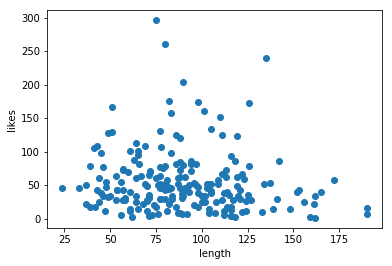

In [299]:
plt.xlabel('length')
plt.ylabel('likes')
plt.scatter(lengths, y)

### Neural machine

What if we try learning on a bigger corpus of [tweets](https://twitter.com/neural_machine)?

In [15]:
from sklearn.cross_validation import train_test_split

/home/vadim/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [65]:
neural_machine = pd.read_json('neural_machine.json')
neural_machine = neural_machine[neural_machine['text'] != '']

In [66]:
neural_machine.head()

,favoriteCount,hashtags,id,images,isPinned,isReplyTo,isRetweet,quote,replyCount,retweetCount,screenName,text,time,urls,userMentions
0,5125,[],923499113433522176,[],True,False,False,NaN,19,1432,neural_machine,Однажды вы найдёте способ сделать свою жизнь л...,2017-10-26T10:38:41.000Z,[],[]
1,889,[],1057711739918319616,[],False,False,False,NaN,16,133,neural_machine,"Я Иисус Христос, Сын Божий, Отец всех верующих...",2018-10-31T19:11:44.000Z,[],[]
2,1674,[],1057255315551514624,[],False,False,False,NaN,6,346,neural_machine,"я люблю тебя, чизкейк, я люблю тебя, я люблю т...",2018-10-30T12:58:04.000Z,[],[]
3,1825,[],1056889090468184064,[],False,False,False,NaN,12,400,neural_machine,"В мире есть нечто большее, чем усталость",2018-10-29T12:42:49.000Z,[],[]
4,2316,[],1056531739403788288,[],False,False,False,NaN,6,508,neural_machine,"я сумасшедший, и у меня есть много aaaaaaaaaaa...",2018-10-28T13:02:50.000Z,[],[]


#### LSTM

In [102]:
X = [sequence_bpe_embed(t) for t in neural_machine['text']]
y = np.array(neural_machine['favoriteCount'])

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [165]:
lstm = nn.LSTM(300, 32, batch_first=True)
regressor = nn.Sequential(nn.Linear(64, 64), nn.LeakyReLU(), nn.Linear(64, 16), nn.LeakyReLU(), nn.Linear(16, 1))
opt = torch.optim.Adam(itertools.chain(lstm.parameters(), regressor.parameters()))
def predict_likes(sentences):
    c0, h0 = normal_dist.sample((1, 1, 32)), normal_dist.sample((1,1,32))
    _, (cn, hn) = lstm(torch.Tensor(sentences), (c0, h0))
    return torch.exp(regressor(torch.cat((cn[0], hn[0]), dim=1)))

In [166]:
def fit_step():
    for sentence, likes in zip(X_train, y_train):
        likes_pred = predict_likes([sentence])
        loss = F.mse_loss(likes_pred, torch.Tensor([[likes]]))
        loss.backward()
        opt.step()
        opt.zero_grad()

In [167]:
from sklearn.metrics import r2_score

def test():
    print(f'train r2 {r2_score(y_train, [predict_likes([sentence]) for sentence in X_train])}')
    print(f'test r2  {r2_score(y_test, [predict_likes([sentence]) for sentence in X_test])}')

In [ ]:
fit_step()
test()

Best r2 on test set: 0.025

#### Different embeddings?

In [ ]:
fasttext = 

#### Bag of words

In [90]:
X = [bpe_embed(t) for t in neural_machine['text']]
y = np.array(neural_machine['favoriteCount'])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [92]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor()

In [93]:
linear.fit(X_train, y_train)
randomforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [94]:
linear.score(X_test, y_test)

-1.1650161642147823

In [95]:
randomforest.score(X_test, y_test)

-0.3233531169364523